# Intalar e Importar las librerias necesarias:

In [71]:
!pip install pmdarima

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt 
from pandas.plotting import register_matplotlib_converters
import datetime 
from datetime import  datetime
from datetime import  timedelta


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from time import time
import warnings
#import seaborn as sns

warnings.filterwarnings("ignore")
#sns.set()

# Consumir la API de Banxico y dar formato a los datos:

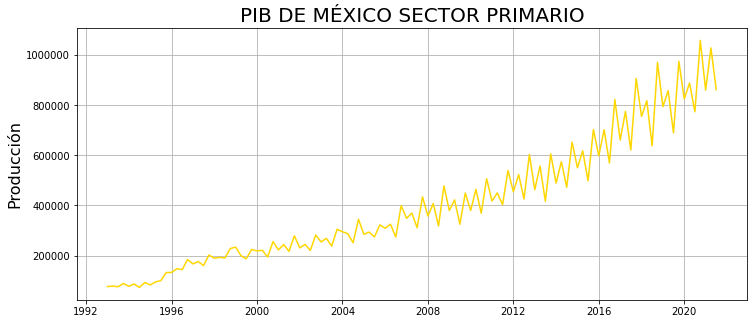

In [213]:
token ="69692bd9a4dcc9cc86207516616f6712abe9b0ef325b4462318ece624b6ff831"
url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR16646/datos/?token={token}"

data = requests.get(url)

df = pd.DataFrame(data.json()['bmx']['series'][0]['datos'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df.set_index("fecha", inplace=True)
df['dato'] = [n[0].replace(',', '') for n in df.values]
df['dato'] =  pd.to_numeric(df['dato'])

pd.options.display.float_format = '{:.5f}'.format

plt.figure(figsize=(12,5))
plt.plot(df, color='gold')
plt.title('PIB DE MÉXICO SECTOR PRIMARIO', fontsize=20)
plt.ylabel('Producción', fontsize=16)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.ticklabel_format(useOffset=False, style='plain', axis='y') 
plt.grid(True)

# Modelo SARIMA (Modelo Autorregresivo Integrado de Medias Móviles Estacional)

In [215]:
# auto sarima
model = auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=4,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)

print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  115
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 4)   Log Likelihood               -1258.348
Date:                             Wed, 02 Feb 2022   AIC                           2526.696
Time:                                     21:28:42   BIC                           2540.199
Sample:                                          0   HQIC                          2532.173
                                             - 115                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9971      0.023    -42.558      0.000      -1.043      -0.951
ma.L1          0.4278      

# Análisis de los residuales:

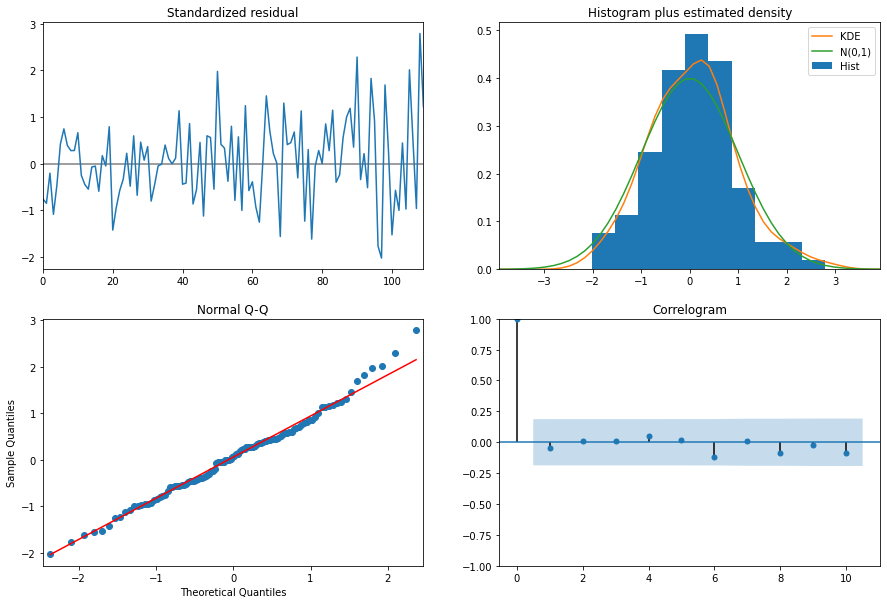

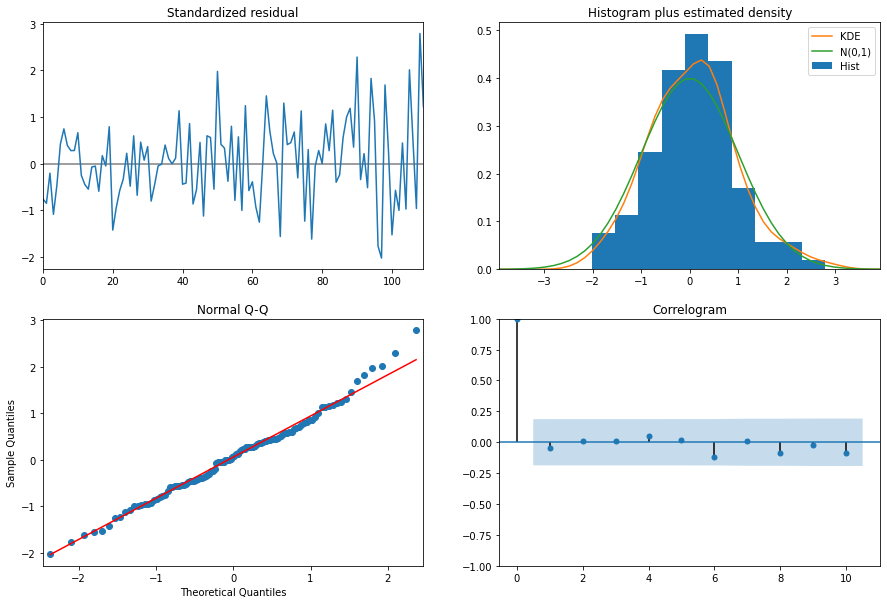

In [218]:
#Fitted residuals
model.plot_diagnostics(figsize=(15, 10))

# Elaborar Pronóstico:

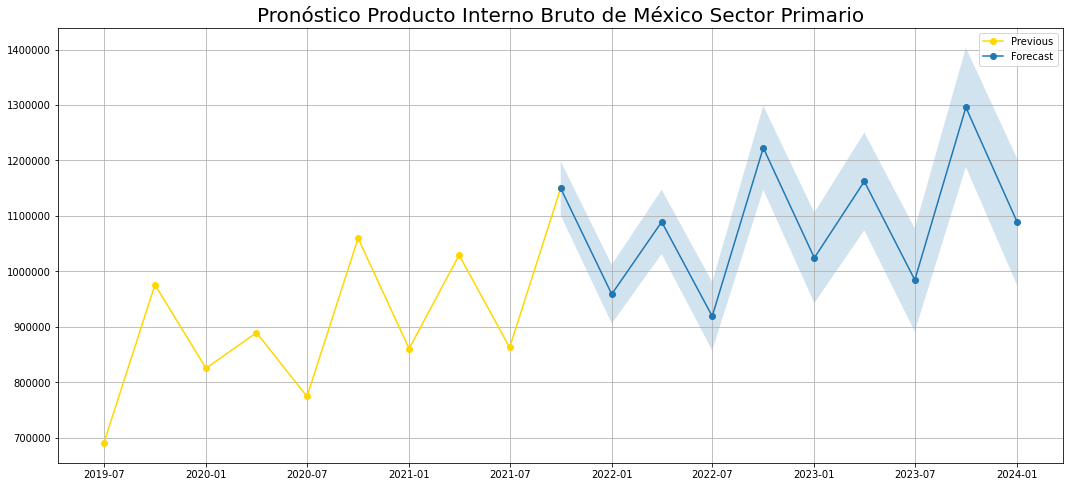

,lower bound,forecast,upper bound
date,,,
2022-01-01,905879.08562,958949.07119,1012019.05676
2022-04-01,1031192.62682,1089238.62995,1147284.63308
2022-07-01,857389.53610,919118.04796,980846.55981
2022-10-01,1146919.32683,1222774.05325,1298628.77968
2023-01-01,942841.67190,1024366.71869,1105891.76548
2023-04-01,1074093.65137,1162205.61604,1250317.58072
2023-07-01,891516.23264,984557.80470,1077599.37676
2023-10-01,1188144.54383,1295718.99485,1403293.44586
2024-01-01,975485.03120,1089828.45537,1204171.87954


In [219]:
pred = model.predict(10, alpha=0.05, return_conf_int=True)

dataframe = {
    'date': [str(n)[:7] + '-01' for n in pd.date_range(df.index[-1] + np.timedelta64(4, 'M'), periods=10, freq='3M')],
    'lower bound': [pred[1][n][0] for n in range(len(pred[1]))],
    'forecast': pred[0],
    'upper bound': [pred[1][n][1] for n in range(len(pred[1]))]
}

predictions = pd.DataFrame(dataframe)
predictions['date'] = pd.to_datetime(predictions['date'], format='%Y-%m-%d')
predictions.set_index('date', inplace=True, drop=True)


m = pd.DataFrame(predictions['forecast'].head(1))
m.columns = ['dato']
f = pd.concat([df, m])

plt.figure(figsize=(18, 8))
plt.plot(f[-10:], color='gold', label='Previous', marker='o')
plt.plot(predictions['forecast'], label='Forecast', marker='o')
plt.legend()
plt.fill_between(predictions.index, predictions['lower bound'], predictions['upper bound'], alpha=0.2)
plt.title('Pronóstico Producto Interno Bruto de México Sector Primario', fontsize=20)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.ticklabel_format(useOffset=False, style='plain', axis='y') 
plt.grid()
plt.show()

predictions[1:]